In [1]:
#Importing libraries
#Installing quantstats
#!pip install quantstats

#Quantstats for fetching Returns of selected companies for further evaluation
import quantstats as qs

#Used to build dataframe by concatenating returns for each comany
import pandas as pd

#storing variable as array
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Importing packages for regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

#computing accuracy
from sklearn.metrics import mean_squared_error, r2_score

For our analysis, we will be evaluating the volatility of stocks based on the "beta" value. Beta is the coefficient to the input factor in a regression equation - in other words, it is the slope of the regression line. Thus, it measures the relationship between two variables. We can use this strategy to see how the daily returns of each stock compare to the market on the whole. For example, if the beta value is high and the slope is steep, the returns may be higher on the whole, but the risk is higher as well, since the stock is not performing in a way that is consistent with the market.

To find beta, we will be examining the daily returns of individual stocks against a benchmark representing the overall market. For these stocks, the benchmark used is the S&P500.

We first need to download the data for each variable in the regression. The code below downloads the daily returns of Apple, Tesla, Microsoft, and Walmart using quantstats from the specified date range.

In [2]:
# Fetching returns (target variable for regression analysis) for our selected companies

#Fetching data for Apple
apple = qs.utils.download_returns('AAPL')
apple = apple.loc['2019-03-11':'2024-03-08']

#Fetching data for Tesla
tesla = qs.utils.download_returns('TSLA')
tesla = tesla.loc['2019-03-11':'2024-03-08']

#Fetching data for Microsoft
microsoft = qs.utils.download_returns('MSFT')
microsoft = microsoft.loc['2019-03-11':'2024-03-08']

#Fetching data for Walmart
walmart = qs.utils.download_returns('WMT')
walmart = walmart.loc['2019-03-11':'2024-03-08']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


The code below combines the daily returns for each stock into a single dataframe, and labels the columns accordingly for easy access of a specific stock's data.

In [3]:
# Concatenating daily returns for each company into one dataframe
stockReturns = pd.concat([apple, tesla, microsoft, walmart], join='outer', axis=1)
stockReturns.columns = ['aapl', 'tsla', 'msft', 'wmt']
stockReturns

,aapl,tsla,msft,wmt
Date,,,,
2019-03-11,0.034642,0.023861,0.020994,0.009120
2019-03-12,0.011235,-0.025987,0.007002,-0.001117
2019-03-13,0.004422,0.019763,0.007745,0.006709
2019-03-14,0.011117,0.003461,0.000786,-0.008179
2019-03-15,0.013008,-0.050110,0.011519,0.002036
...,...,...,...,...
2024-03-04,-0.025381,-0.071555,-0.001396,0.009190
2024-03-05,-0.028441,-0.039332,-0.029572,0.012479
2024-03-06,-0.005878,-0.023238,-0.001391,0.008827


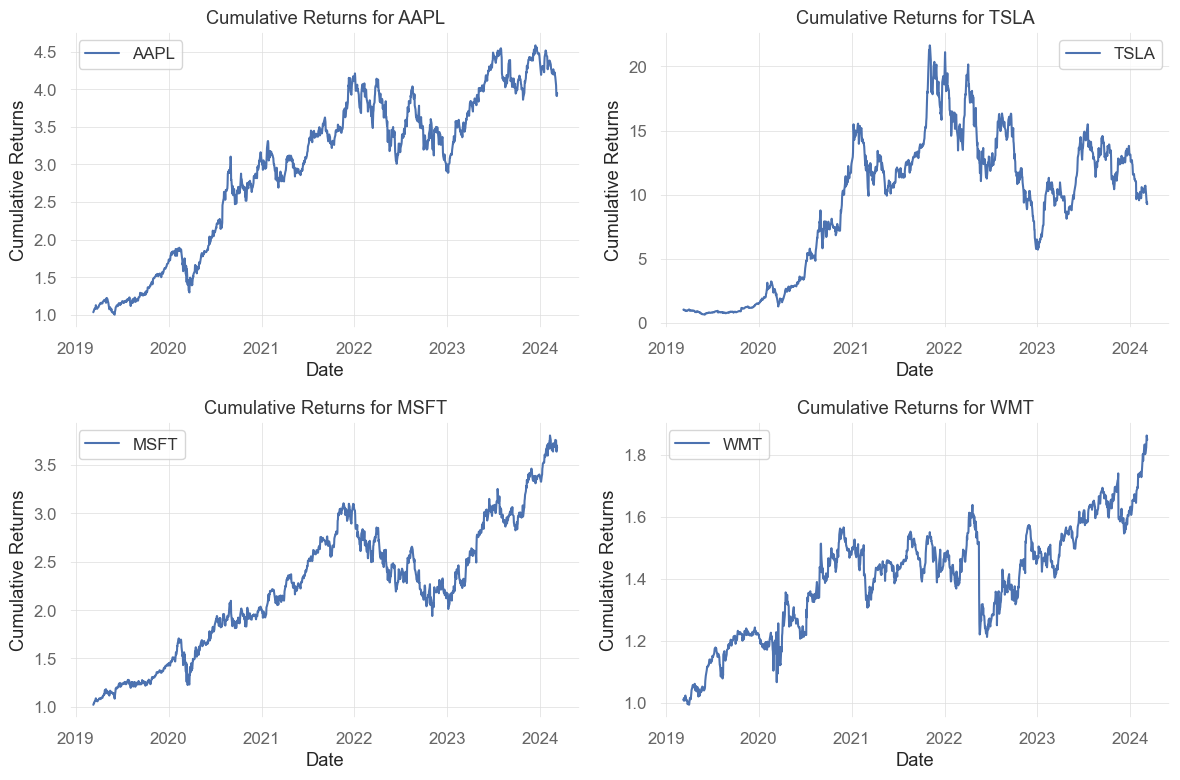

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming stockReturns contains the daily returns data as you've defined earlier

# Convert daily returns to cumulative returns
cumulative_returns = (stockReturns + 1).cumprod()

# Plotting separate cumulative returns for each company in a 2x2 matrix
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for i, column in enumerate(cumulative_returns.columns):
    axs[i].plot(cumulative_returns.index, cumulative_returns[column], label=column.upper())
    axs[i].set_title(f'Cumulative Returns for {column.upper()}')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Cumulative Returns')
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()

This code downloads the daily returns of the S&P 500 on the whole, and stores it as "sp500_returns". A sample of the data is outputted.

In [5]:
# Download S&P 500 index data for benchmarking
#'^GSPC' helps fetching historical data for S&P 500 index
sp500 = qs.utils.download_returns('^GSPC')
sp500 = sp500.loc['2019-03-11':'2024-03-08']
sp500Returns = sp500
sp500Returns

[*********************100%%**********************]  1 of 1 completed


Date
2019-03-11    0.014666
2019-03-12    0.002953
2019-03-13    0.006950
2019-03-14   -0.000868
2019-03-15    0.004985
                ...   
2024-03-04   -0.001193
2024-03-05   -0.010193
2024-03-06    0.005141
2024-03-07    0.010304
2024-03-08   -0.006529
Name: Close, Length: 1259, dtype: float64

Before we can model with the data, we need to examine and clean it to ensure that the data is consistently formatted with no missing values or otherwise dirty data. This code shows how any missing data was dropped, and verifies that there is not missing data left.

In [6]:
#Cleaning the data
#Dropping missing values
stocksReturns=stockReturns.dropna()
#Checking to make sure no missing stock data
stocksReturns.isnull().sum()

aapl    0
tsla    0
msft    0
wmt     0
dtype: int64

In [7]:
#Cleaning the data
#Dropping missing values
sp500Returns=sp500Returns.dropna()
#Checking to make sure no missing SP500 data
sp500Returns.isnull().sum()

0

Another part of cleaning the data involves locating and managing outliers. The code below generates boxplots for each individual stock that we are evaluating. This allows use to see any outliers, shown as dots on the boxplots. While each dataset does have a number of outliers, we have decided to leave them in in order to ensure the integrity of the data is maintained. Because the data was not inputted by a human, it is highly unlikely that these outliers are a result of data collection errors. They are likely a result of natural variation and the inherent risk of the stock market.

Further, these plots help us visualize the data. We can see the general distribution of the daily returns for each stock, which can help us understand risk for each a little bit better prior to modeling. For example, the distribution of returns for Walmart during this time period is small relative to the other stocks. This implies that the daily returns are more consistent and the risk may be lower.

Text(0.5, 0, 'Returns')

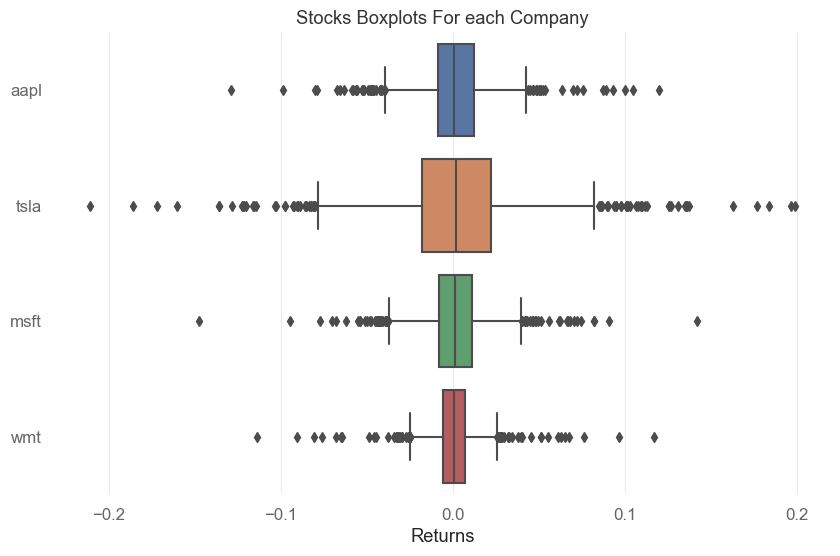

In [8]:
#Visualizing the distribution of returns and examining outliers
sns.boxplot(data=stockReturns, orient='h')
plt.title('Stocks Boxplots For each Company')
plt.xlabel('Returns')

Since we are using beta as a measure of risk, and beta is generated as part of a regression, we need to visualize the relationship between each stock and the overall market, again represented by the S&P 500. This code creates scatterplots using the individual stock returns on the y-axis and the S&P 500 returns on the x-axis in order to help us explore this relationship.

By analyzing these plots, we can determine what models might be appropriate for each stock. For example, the relationship between the Apple and Microsoft returns and the S&P 500 returns seems fairly linear, as opposed to a curved line. On the other hand, the relationship between the Tesla and Walmart returns and the S&P 500 returns appear less linear, and a different kind of model may be a better fit.

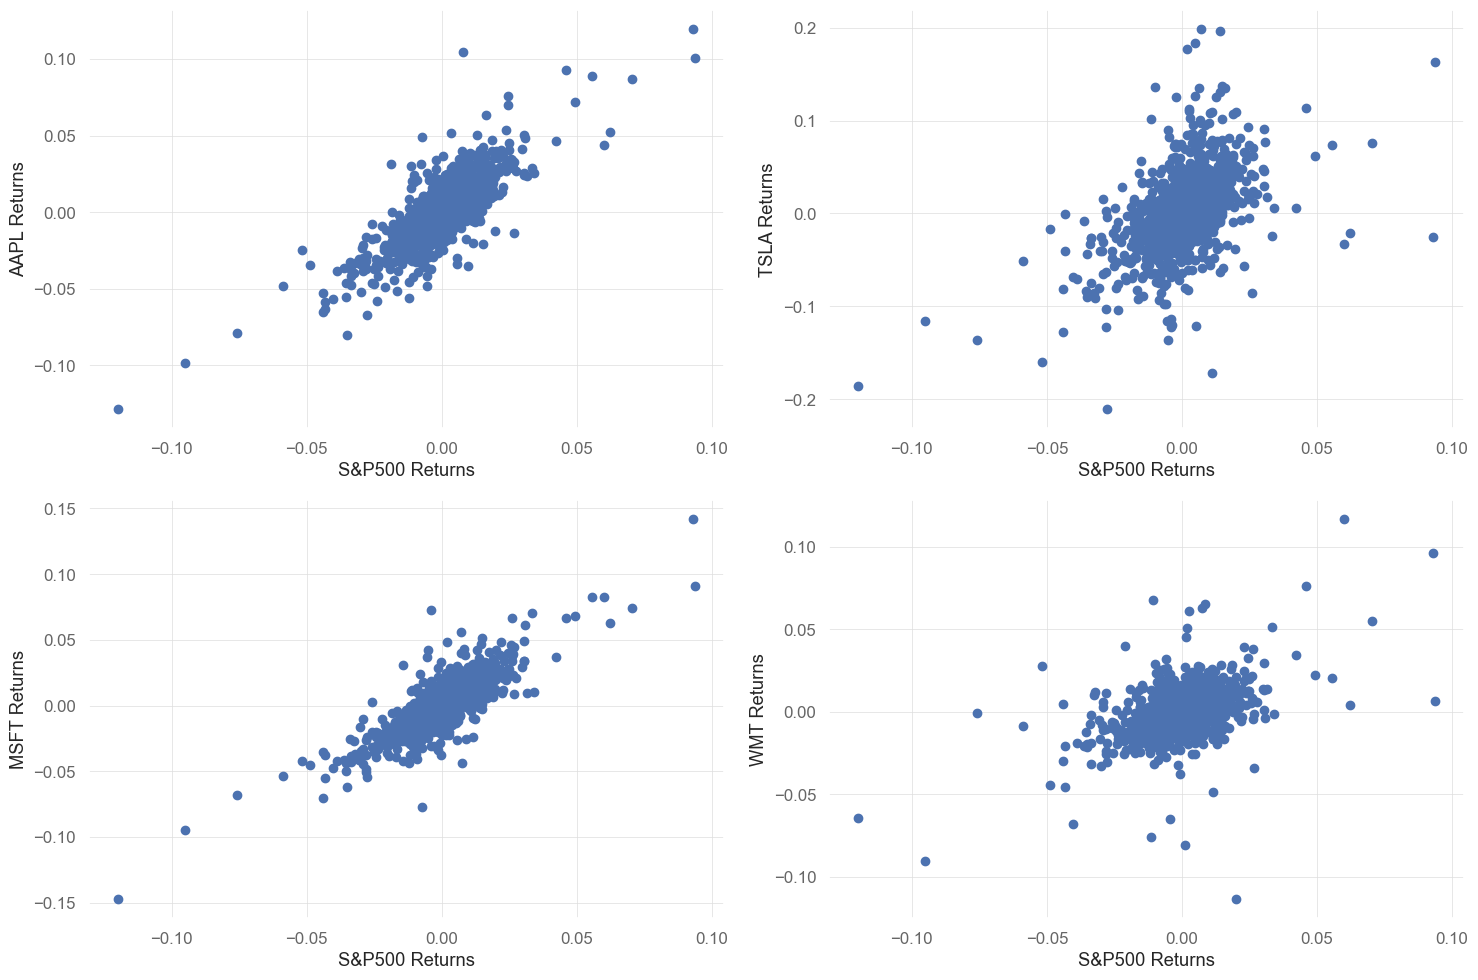

In [9]:
# Visualize relationship between company returns and S&P500 returns
#Generating a figure to see the scatter plots in a 2X2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

#Storing company names as tickers to be iterated through for our analysis.
# List of company names and their corresponding stock returns
company_tickers = ['aapl', 'tsla', 'msft', 'wmt']

#loop that iterates through each item in the list company, and enumerate is used to return both index and values associated with each item of the list 'companies'
for i, company in enumerate(company_tickers):
    # Scatter plot between each companies returns and sp 500 index
    #the following piece of code generates 2X2 grid of scatter plot on row index reffered by i//2 and column index as i%2. e.g. index of i=apple is 0 and for column=i%2 is also 0, thus generatin plot at axes[0,0].
    axes[i//2, i%2].scatter(sp500Returns, stockReturns[company])
    axes[i//2, i%2].set_xlabel('S&P500 Returns')
    axes[i//2, i%2].set_ylabel(f'{company.upper()} Returns')

#prevents overlapping of scatter plots
plt.tight_layout()
#viewing the scatter plot
plt.show()

The coefficient of determination, known also as "R-square", is a value frequently used to measure how well a model fits the data. R-square measures the proportion of the variation in the target variable (the stock's returns) that is explained by the regression model (Jaggia & Kelly, 2022). For example, a model with an R-square of 0.5 explains 50% of the variation in the target variable.

We will be using it to examine how well the model fits the data, in order to determine whether the beta-value from each model is well suited to tell us about the stock's volatility.

The function defined in the code below will output the Mean Squared Error and the R-square value for each model.

The risk classification function will be used for our primary goal of categorizing stocks as low-risk or high risk. When evalutation beta values, the S&P 500 is considered to have a beta of 1.0. A beta above that indicates that a stock is more volatile than the market overall. For example, if a stock's beta value based on a regression is 1.3, that stock is considered 30% risker than the market baseline. This is the rationale for the ranges that we chose when categorizing stocks as either low- or high-risk.

In [10]:
# Function to evaluate model accuracy to assist our analysis
def accuracyEvaluation(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, r2

In [11]:
# Function that classifies Companies under High/Low risk categories.We set Beta threshold as 1. Beta greater than one for the comapny suggests high risk, and beta lower than one suggests low risk.
def classifyRisk(beta):
    if beta > 1:
        return 'High Risk'
    else:
        return 'Low Risk'

After looking at the scatterplots for each stock, we decided to try linear regression models and polynomial regression models. These models could be used to predict the stock's returns based on the performance of the S&P 500.

It is of particular interest to us for classification, however, because the models find the exact line that minimizes error between the datapoints based on our parameters. The slope of this line is the beta-value we are seeking to evaluate the stock's riskiness.

We are running multiple kinds of models because we would like to use the beta value from the model that best fits our data. The code below runs linear regression and polynomial regression for each of the four subject stocks, and outputs a visualization, the Mean Square Error (MSE) and the R-square for the model. We can use these to determine what models best fit the data.

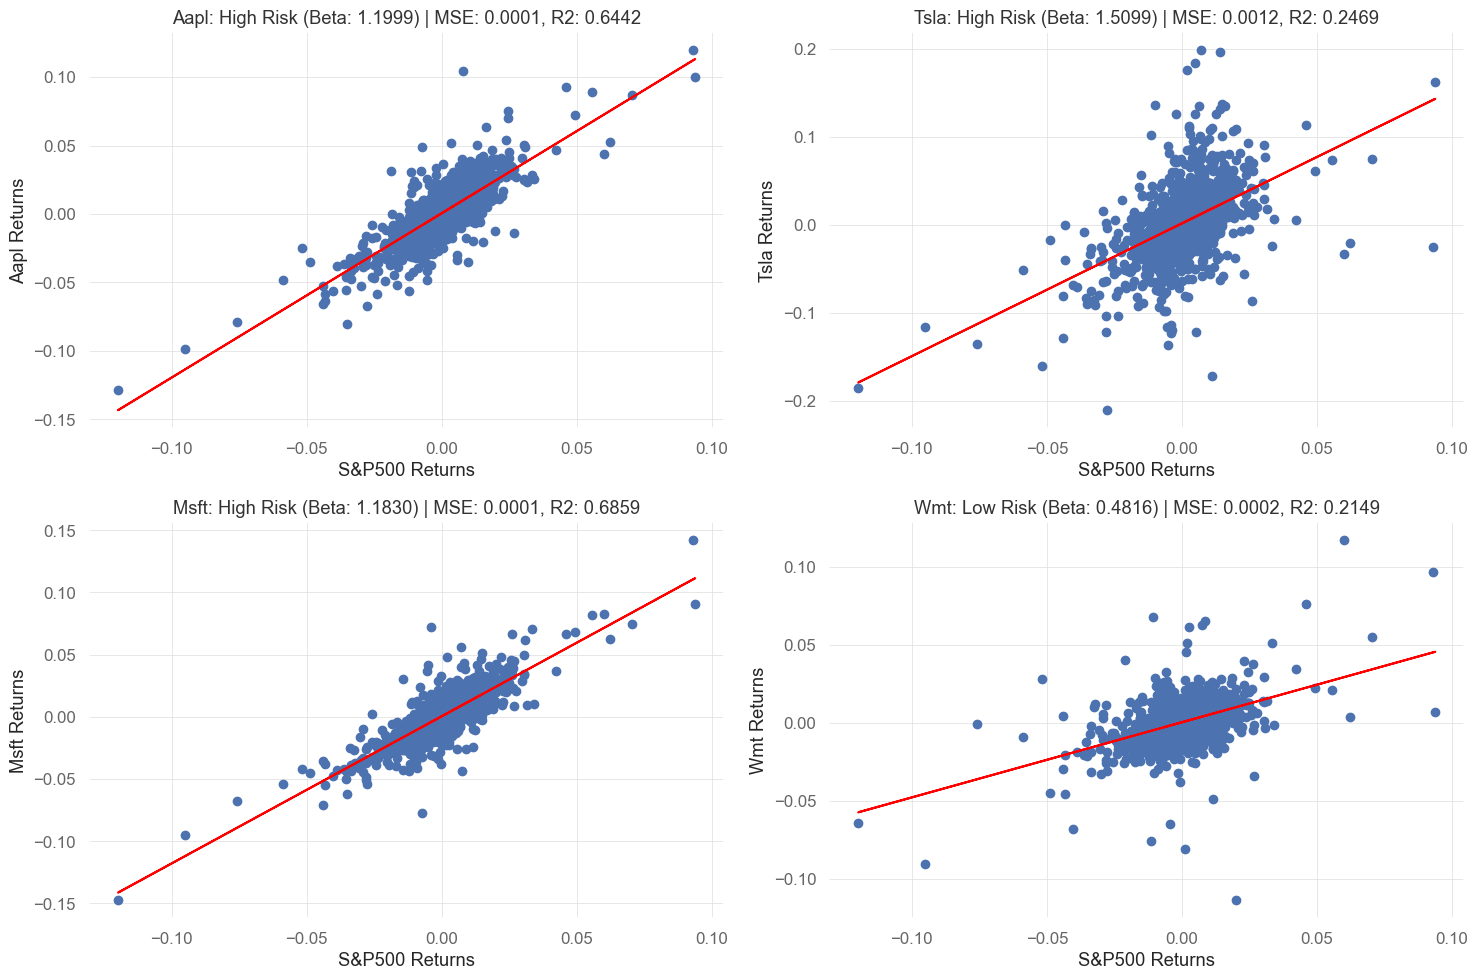

In [12]:
# Perform linear regression and plot scatter plots with regression lines
#Generating a figure to see the scatter plots in a 2X2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

#loop that iterates through each item in the list company, and enumerate is used to return both index and values associated with each item of the list 'companies'
for i, company in enumerate(company_tickers):
    # Performing linear regression
    #Fitting model between between x=S&P 500 returns and y=Company Resturns
    #reshaping as scikit-learn uses a 2d array
    regression = LinearRegression().fit(sp500Returns.values.reshape(-1, 1), stockReturns[company].values.reshape(-1, 1))

    #prediction company returns for each company based on fitted model and S&P 500 returns
    #reshaping as scikit-learn uses a 2d array
    y_pred = regression.predict(sp500Returns.values.reshape(-1, 1))

    #evaluating accuracy
    mse, r2 = accuracyEvaluation(stockReturns[company], y_pred)

    # Scatter plot
    #the following piece of code generates 2X2 grid of scatter plot on row index reffered by i//2 and column index as i%2.
    axes[i//2, i%2].scatter(sp500Returns, stockReturns[company])
    # Fitting the regression line
    axes[i//2, i%2].plot(sp500Returns, regression.predict(sp500Returns.values.reshape(-1, 1)), color='red')
    axes[i//2, i%2].set_xlabel('S&P500 Returns')
    axes[i//2, i%2].set_ylabel(f'{company.capitalize()} Returns')
    axes[i//2, i%2].set_title(f'{company.capitalize()}: {classifyRisk(regression.coef_[0][0])} (Beta: {regression.coef_[0][0]:.4f}) | MSE: {mse:.4f}, R2: {r2:.4f}')

#prevents overlapping of scatter plots
plt.tight_layout()
#viewing the scatter plot
plt.show()

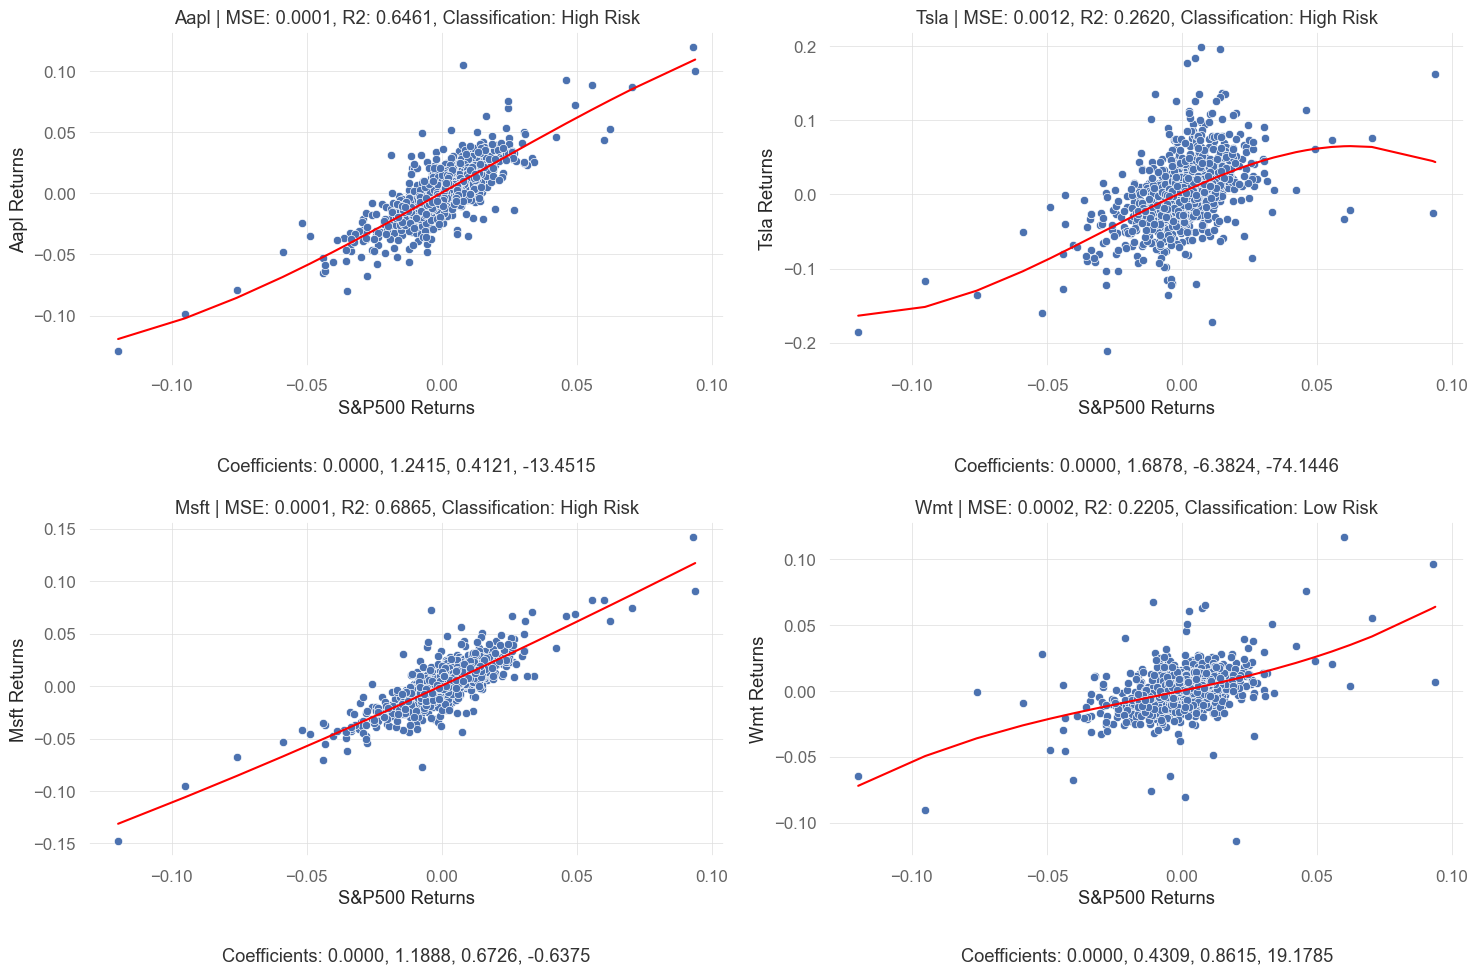

In [13]:
# Perform polynomial regression and plot scatter plots with regression curves
#Generating a figure to see the scatter plots in a 2X2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, company in enumerate(company_tickers):
    # Creating polynomial features
    #creating polynomial instance with degree three suggesting creation upto third degree
    poly_features = PolynomialFeatures(degree=3)
    sp500Returns_poly = poly_features.fit_transform(sp500Returns.values.reshape(-1, 1))

    # Fitting polynomial regression model
    regression_poly = LinearRegression().fit(sp500Returns_poly, stockReturns[company])
    # Predict
    y_pred_poly = regression_poly.predict(sp500Returns_poly)

    # Evaluating accuracy
    mse_poly, r2_poly = accuracyEvaluation(stockReturns[company], y_pred_poly)

    #Fetchin Coefficients(Beta) for classification
    coeff = regression_poly.coef_

    # Scatter plot
    sns.scatterplot(x=sp500Returns.values.reshape(-1), y=stockReturns[company], ax=axes[i//2, i%2])
    # Fitting Regression curve
    sns.lineplot(x=sp500Returns.values.reshape(-1), y=regression_poly.predict(sp500Returns_poly), color='red', ax=axes[i//2, i%2])
    axes[i//2, i%2].set_xlabel('S&P500 Returns')
    axes[i//2, i%2].set_ylabel(f'{company.capitalize()} Returns')
    axes[i//2, i%2].set_title(f'{company.capitalize()} | MSE: {mse_poly:.4f}, R2: {r2_poly:.4f}, Classification: {classifyRisk(coeff[1])}')

    # Print coefficients below the plot
    coeff_str = ", ".join([f"{coeff:.4f}" for coeff in coeff.flatten()])
    axes[i//2, i%2].text(0.5, -0.3, f'Coefficients: {coeff_str}', horizontalalignment='center', verticalalignment='center', transform=axes[i//2, i%2].transAxes)

#prevents overlapping of scatter plots
plt.tight_layout()
#viewing the scatter plot
plt.show()

After the a linear regression and a polynomial regression has been run for each of the four stocks, we can evaluate the fit of each and classify them based on Beta values.  

For the linear regression models:

* Apple Regression R-Square: 0.6442
* Tesla Regression R-Square: 0.2469
* Microsoft Regression R-Square: 0.6859
* Walmart Regression R-Square: 0.2149

For the polynomial regression models (degree=3):

* Apple Regression R-Square: 0.6461
* Tesla Regression R-Square: 0.2620
* Microsoft Regression R-Square: 0.6865
* Walmart Regression R-Square: 0.2205

As indicated by these measures, both models fit the Apple and Microsoft Stocks significantly more than either model fit the Tesla and Walmart stocks. The polynomial model proved to be a better fit for all of the stocks than the respective linear models, but the difference in fit is very small, and would not always justify the use of a more complex model.

Note: Neither model fit the Tesla and Walmart data well. Further machine learning implementation attempts will consider alternative models.


To classify the stocks as low-risk or high-risk, we can utilize the beta values from the regression equations. As described above, both models fit the data similarly in the case of each stock.

For each stock, the beta values from the linear and polynomial models were very close and led to the same classification:

* Apple: High Risk
* Tesla: High Risk
* Microsoft: High Risk
* Walmart: Low Risk

Note: In the polynomial models, we examined the second coefficient listed in order to be as consistent in our evaluation as possible, because that coefficient is directly for the S&P 500 Returns.

**Citations (used for text descriptions):**

---
Jaggia, S. & Kelly, A. (2022). Business Statistics: Communicating with Numbers (4th ed.). McGraw Hill LLC.

Kenton, W. (2024, February 22). Beta: Definition, Calculation, and Explanation for Investors. Investopedia.
